<a href="https://colab.research.google.com/github/Kritarth-Dandapat/CSE-473-Marine-Guardian/blob/master/Basic%20Model%20and%20data%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Marine Guardian: Satellite Image Ship Detection
KRITARTH DANDAPAT     UBID: 5052318

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## 1. Data Loading and Exploration



### 1.1 Load the Dataset

-   Download the dataset from Kaggle and extract it to a local directory.
-   Load the images and their corresponding labels (if available).
-   Explore the dataset to understand its structure and content.

In [2]:
import os
import subprocess

dataset_slug = "rhammell/ships-in-satellite-imagery"
destination_path = "./ships_dataset"
unzip = True

try:
    os.makedirs(destination_path, exist_ok=True)

    dataset_name = dataset_slug.split("/")[1]

    if unzip:
        if any(os.path.exists(os.path.join(destination_path, item)) for item in os.listdir(destination_path) if dataset_name in item):
            print(f"Dataset '{dataset_slug}' appears to already exist in '{destination_path}'. Skipping download.")
        else:
            command = f"kaggle datasets download -d {dataset_slug} -p {destination_path} --unzip"
            subprocess.run(command, shell=True, check=True)
            print(f"Dataset '{dataset_slug}' downloaded successfully to '{destination_path}'.")

    else:
        if os.path.exists(os.path.join(destination_path, f'{dataset_name}.zip')):
            print(f"Dataset '{dataset_slug}' appears to already exist in '{destination_path}'. Skipping download.")
        else:
            command = f"kaggle datasets download -d {dataset_slug} -p {destination_path}"
            subprocess.run(command, shell=True, check=True)
            print(f"Dataset '{dataset_slug}' downloaded successfully to '{destination_path}'.")

except subprocess.CalledProcessError as e:
    print(f"Error downloading dataset '{dataset_slug}': {e}")
except FileNotFoundError:
    print("Kaggle API not found. Please ensure the Kaggle CLI is installed and configured.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset 'rhammell/ships-in-satellite-imagery' downloaded successfully to './ships_dataset'.


### 1.2 Data Visualization

-   Display sample images to visualize the challenges of satellite imagery.
-   Analyze the distribution of ship sizes and orientations.
-   Identify potential sources of noise and variability.

In [3]:
import os

dataset_path = destination_path + "/shipsnet/shipsnet"

try:
    image_files = os.listdir(dataset_path)

    image_files = [f for f in image_files if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise FileNotFoundError(f"No image files found in '{dataset_path}'.")

    ship_count = 1
    no_ship_count = 1

    for old_name in image_files:
        old_path = os.path.join(dataset_path, old_name)
        parts = old_name.split("_")
        label = parts[0]

        if label == "1": # ship
            new_name = f"S {ship_count:05d}.png"
            ship_count += 1
        elif label == "0": # no ship
            new_name = f"NS {no_ship_count:05d}.png"
            no_ship_count += 1
        else:
            print(f"Warning: Invalid label '{label}' in file '{old_name}'. Skipping.")
            continue  # Skip files with invalid labels

        new_path = os.path.join(dataset_path, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' to '{new_name}'")

    print("All files renamed successfully.")

except FileNotFoundError as e:
    print(e)
except FileExistsError as e:
        print(f"File already exists: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

Renamed '0__20170515_180653_1007__-122.4739946106464_37.79226435387626.png' to 'NS 00001.png'
Renamed '0__20171203_185451_0f2b__-122.3328807412968_37.748611424156486.png' to 'NS 00002.png'
Renamed '0__20180206_184438_1043__-122.37560670104995_37.729620437060554.png' to 'NS 00003.png'
Renamed '0__20170703_180946_1009__-122.21880809779623_37.68006874164405.png' to 'NS 00004.png'
Renamed '0__20161006_002711_1_0c1b__-122.32059617641094_37.75884324448535.png' to 'NS 00005.png'
Renamed '0__20170101_180917_0e30__-122.57202138891589_37.7513177333551.png' to 'NS 00006.png'
Renamed '1__20180707_180451_102e__-118.2289682358873_33.72904710059676.png' to 'S 00001.png'
Renamed '0__20170822_181223_0f31__-122.33926303458964_37.76614184445857.png' to 'NS 00007.png'
Renamed '1__20170522_180635_0f42__-122.34140533621209_37.74733443586415.png' to 'S 00002.png'
Renamed '1__20170615_180728_1003__-122.32566478605885_37.72948052351617.png' to 'S 00003.png'
Renamed '0__20170830_181004_0f4e__-122.17832386203119

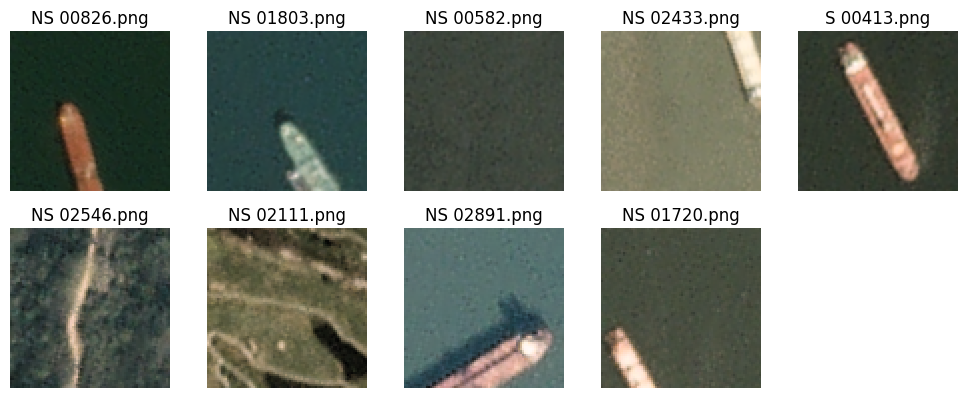

In [4]:
import random

dataset_path = destination_path + "/shipsnet/shipsnet"

try:
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise FileNotFoundError(f"No image files found in '{dataset_path}'.")

    num_images_to_display = min(9, len(image_files))  # Display up to 9 images
    random_images = random.sample(image_files, num_images_to_display)

    plt.figure(figsize=(10, 10))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(dataset_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

In [18]:
import os
import tensorflow as tf

def create_dataset(path, batch_size=32):
    """Creates a dataset from images in a directory with labels."""

    # Get list of image file paths
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Assign labels based on filename containing 'ship ' (with space)
    labels = [1 if os.path.basename(f).lower().startswith('s ') else 0 for f in image_files]

    # Convert lists to tensors
    image_files = tf.convert_to_tensor(image_files, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    def load_image(image_path, label):
        """Loads an image and returns the image tensor along with its label."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Adjust for PNG if necessary
        return image, label  # Ensure label is returned with the image

    # Create dataset with image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Example usage
dataset_path = '/content/ships_dataset/shipsnet/shipsnet'  # Replace with your dataset path
dataset = create_dataset(dataset_path)

# Check the dataset output
for batch_images, batch_labels in dataset.take(1):
    print("Batch image shape:", batch_images[0].shape)
    print("Batch labels:", batch_labels.numpy())


Batch image shape: (80, 80, 3)
Batch labels: [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0]


In [19]:
## verifying the processing of the image
batch[0].numpy()

NameError: name 'batch' is not defined

## Basic Data Augementation

In [20]:
def augment_image(image, label):
    """Applies random augmentations to an image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [21]:
augmented_dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

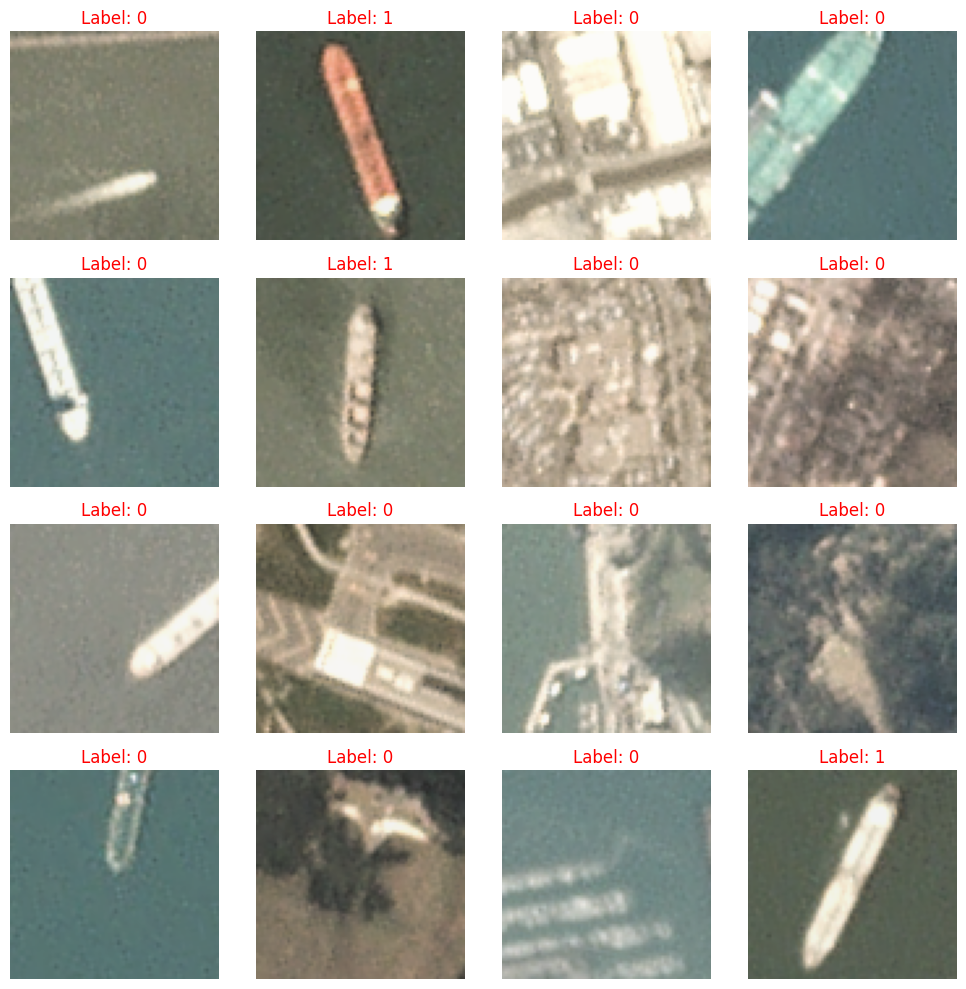

In [22]:
import matplotlib.pyplot as plt

# Set up the figure with a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # 4x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy indexing

for images, labels in augmented_dataset.take(1):  # Take a single batch
    num_images = min(16, images.shape[0])  # Ensure we don't exceed batch size

    for j in range(num_images):
        image = images[j].numpy()  # Convert to NumPy array
        label = labels[j].numpy()  # Convert label to NumPy

        # If images are normalized, rescale to [0, 255]
        if image.max() <= 1.0:
            image = (image * 255).astype('uint8')

        axes[j].imshow(image)
        axes[j].axis('off')  # Turn off axis
        axes[j].set_title(f"Label: {label}", fontsize=12, color='red')  # Show label

# Remove any unused subplots (in case batch < 16)
for j in range(num_images, 16):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [23]:
def preprocess_image(image, label, target_size=(80, 80)):
    """Preprocessing function that resizes and normalizes the image tensor."""
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

preprocessed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

for batch_images, batch_labels in preprocessed_dataset.take(1):
    print("Preprocessed batch image shape:", batch_images[0].shape)
    print("Preprocessed batch labels:", batch_labels.numpy())

Preprocessed batch image shape: (80, 80, 3)
Preprocessed batch labels: [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0]


In [24]:
dataset_size = 125 # this is the number of bacthes orughly 4008/32 is 125
dataset = preprocessed_dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

# Split the dataset into train (70%), validation (15%), and test (15%)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

train_count = sum(1 for _ in train_dataset)
val_count = sum(1 for _ in val_dataset)
test_count = sum(1 for _ in test_dataset)

# Example: Print sizes of datasets and shapes of batches
print(f"Train dataset size (batches): {train_count}")
print(f"Validation dataset size (batches): {val_count}")
print(f"Test dataset size (batches): {test_count}")

# Print the shape of a sample batch from each dataset
for images, label in train_dataset.take(1):
    print("\n\nTrain batch shape:", images.shape)

for images, label in val_dataset.take(1):
    print("Validation batch shape:", images.shape)

for images, label in test_dataset.take(1):
    print("Test batch shape:", images.shape)


Train dataset size (batches): 87
Validation dataset size (batches): 18
Test dataset size (batches): 20


Train batch shape: (32, 80, 80, 3)
Validation batch shape: (32, 80, 80, 3)
Test batch shape: (32, 80, 80, 3)


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models


input_shape = (80, 80, 3)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Input layer for images
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),  # Flatten to feed into fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

# Print model summary to check layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 80, 80, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7972 - loss: 0.4105 - val_accuracy: 0.9306 - val_loss: 0.1804
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9156 - loss: 0.2215 - val_accuracy: 0.9392 - val_loss: 0.1398
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9309 - loss: 0.1781 - val_accuracy: 0.9514 - val_loss: 0.1220
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9388 - loss: 0.1438 - val_accuracy: 0.9705 - val_loss: 0.0697
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9662 - loss: 0.0949 - val_accuracy: 0.9774 - val_loss: 0.0621


In [27]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9748 - loss: 0.0648
Test accuracy: 96.56%


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9748 - loss: 0.0648


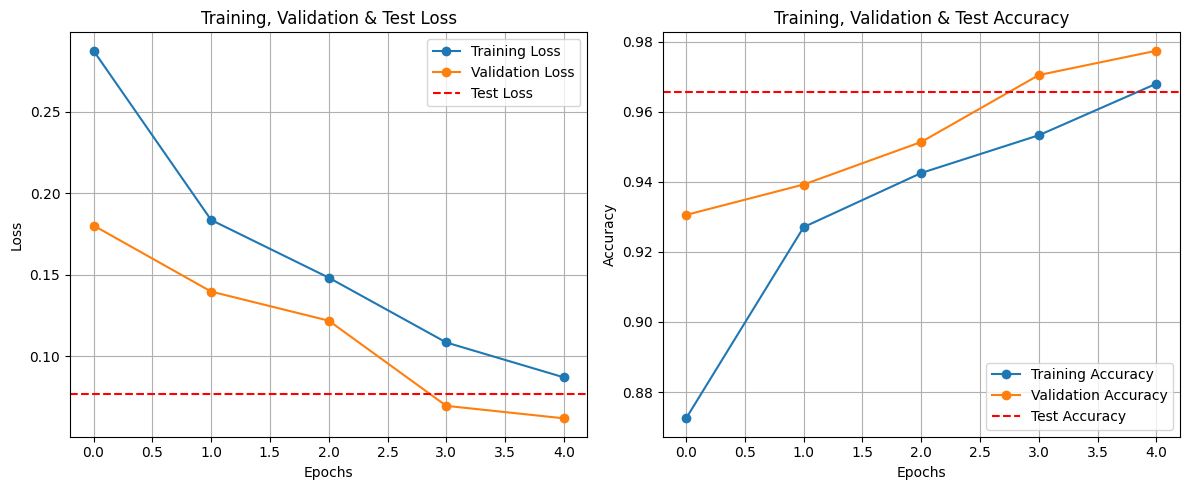

In [29]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Extract loss and accuracy values from training history
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Horizontal test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation & Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
if 'accuracy' in history_dict:  # Some models may use 'acc' instead of 'accuracy'
    plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Horizontal test accuracy line
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation & Test Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()
